###How to run
1. Upload test_landmark.csv, train_landmarks.csv file in colab.
2. Run cells with cpu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

              precision    recall  f1-score   support

           A       0.04      0.04      0.04       203
           B       0.03      0.03      0.03       207
           C       0.05      0.05      0.05       218
           D       0.08      0.07      0.07       223
           E       0.03      0.03      0.03       232
           F       0.05      0.05      0.05       194
           G       0.05      0.05      0.05       213
           H       0.05      0.05      0.05       220
           I       0.03      0.03      0.03       193
           J       0.05      0.06      0.05       199
           K       0.02      0.02      0.02       233
           L       0.03      0.02      0.03       201
           M       0.03      0.04      0.04       192
           N       0.04      0.03      0.03       230
           O       0.03      0.03      0.03       213
           P       0.04      0.03      0.04       204
           Q       0.03      0.03      0.03       186
           R       0.05    

Text(0.5, 1.0, 'Learning Curve')

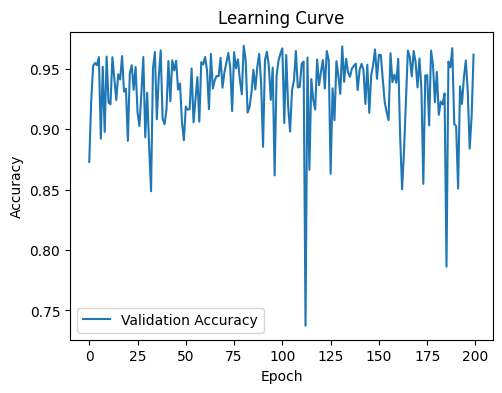

In [ ]:
#Read csv file
train_file = 'train_landmarks.csv'
test_file = 'test_landmarks.csv'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

#Drop the header
X = train.drop('label', axis=1).values
y = train['label'].values

X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Label encoding (Alphabet -> Number)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

# Divide into validation data/ training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform to Tensor
X_train, X_test, y_train, y_test, X_valid, y_valid = map(torch.tensor, (X_train, X_test, y_train, y_test, X_valid, y_valid))

# Data Loader
train_dataset = TensorDataset(X_train.float(), y_train.long())
valid_dataset = TensorDataset(X_valid.float(), y_valid.long())
test_dataset = TensorDataset(X_test.float(), y_test.long())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Architecture
class SimpleDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

input_size = X_train.size(1)
hidden_size1 = 128
hidden_size2 = 64
output_size = len(np.unique(y))
model = SimpleDNN(input_size, hidden_size1, hidden_size2, output_size)
cross_entropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)

train_losses = []
valid_losses = []
accuracies = []

#Training
num_epochs = 200
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = []
        valid_loss = 0.0
        total = 0
        correct = 0
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = cross_entropy(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        validation_loss = valid_loss / len(valid_loader)
        valid_losses.append(validation_loss)
        accuracy = correct / total
        accuracies.append(accuracy)

# print(f'Validation loss:',validation_loss)

print(classification_report(y_valid, y_pred, target_names=label_encoder.classes_))


# Learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# plt.plot(valid_losses, label='Validation Loss')
plt.plot(accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')


Test Accuracy: 95.91%
              precision    recall  f1-score   support

           A       0.97      1.00      0.99       263
           B       0.95      1.00      0.98       263
           C       0.97      0.99      0.98       263
           D       0.98      0.89      0.93       263
           E       0.99      0.96      0.97       263
           F       1.00      0.97      0.98       263
           G       0.98      0.99      0.98       263
           H       0.98      0.98      0.98       263
           I       1.00      0.96      0.98       263
           J       0.94      1.00      0.97       263
           K       1.00      0.93      0.96       263
           L       1.00      0.99      0.99       263
           M       0.76      0.93      0.84       263
           N       0.99      0.69      0.81       263
           O       0.86      0.99      0.92       263
           P       0.98      0.94      0.96       263
           Q       0.93      0.98      0.96       263
     

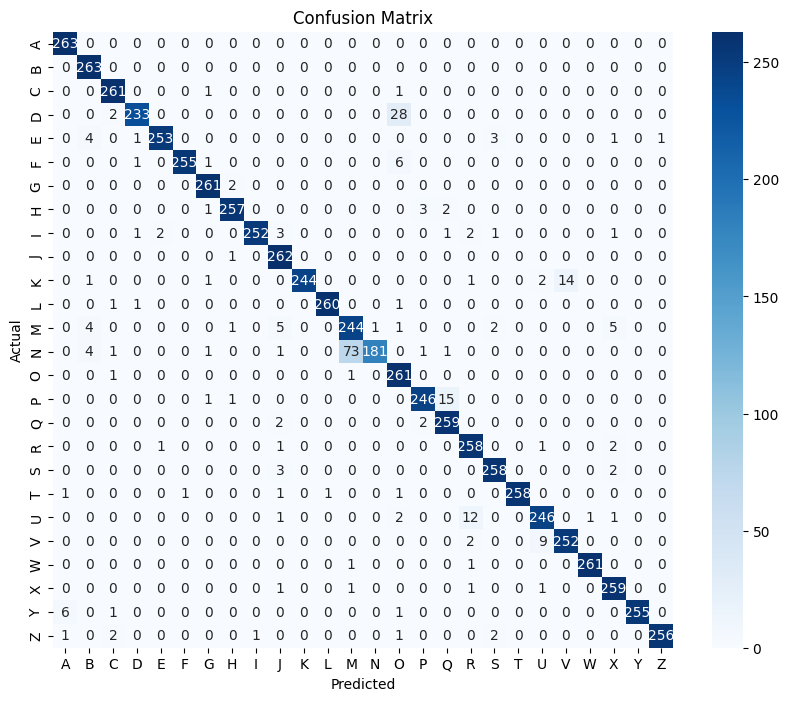

Weighted Precision: 0.9623
Weighted Recall: 0.9591
Weighted F1 Score: 0.9588


In [ ]:
# Use the best model for evaluation on the test set
model.eval()
y_test_pred = []
with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy and generate confusion matrix
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# y_test = y_test.numpy()
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Alphabet -> Number for confusion Matrix
label_encoder.classes_ = [chr(ord('A') + i) for i in range(26)]

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_recall_fscore_support


# Calculate precision, recall, f1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')

